In [41]:
#Import the required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
import lightgbm as lgb
import random
import os
from sklearn.model_selection import GridSearchCV
import shutil

sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [42]:
# Fetching data from Tushare
import tushare as ts
# 初始化pro接口
pro = ts.pro_api('4490452b6b447107d2e5414c01f4fdbc29653b7fc6b1d2c85bcb0073')

index_code = '399001.SZ'

test_year = 3


#创建一个拉取数据的函数
def get_data(stock):

    # 拉取数据
    daily_basic = pro.daily_basic(**{
        "ts_code": stock,
        "trade_date": "",
        "start_date": "",
        "end_date": 20230619,
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "close",
        "turnover_rate",
        "turnover_rate_f",
        "volume_ratio",
        "pe",
        "pe_ttm",
        "pb",
        "ps",
        "ps_ttm",
        "dv_ratio",
        "dv_ttm",
        "total_share",
        "float_share",
        "free_share",
        "total_mv",
        "circ_mv"
    ])
    moneyflow = pro.moneyflow(**{
    "ts_code": stock,
    "trade_date": "",
    "start_date": "",
    "end_date": 20230619,
    "limit": "",
    "offset": ""

}, fields=[
    "ts_code",
    "trade_date",
    "buy_sm_vol",
    "buy_sm_amount",
    "sell_sm_vol",
    "sell_sm_amount",
    "buy_md_vol",
    "buy_md_amount",
    "sell_md_vol",
    "sell_md_amount",
    "buy_lg_vol",
    "buy_lg_amount",
    "sell_lg_vol",
    "sell_lg_amount",
    "buy_elg_vol",
    "buy_elg_amount",
    "sell_elg_vol",
    "sell_elg_amount",
    "net_mf_vol",
    "net_mf_amount",
])
    df = pd.merge(daily_basic, moneyflow, on='trade_date', how='left')
    
#     tech = pro.stk_factor(**{
#     "ts_code": stock,
#     "start_date": "",
#     "end_date": 20230619,
#     "trade_date": "",
#     "limit": "",
#     "offset": ""
# }, fields=[
#     "trade_date",
#     "cci",
#     "boll_lower",
#     "boll_mid",
#     "boll_upper",
#     "rsi_24",
#     "rsi_12",
#     "rsi_6",
#     "kdj_j",
#     "kdj_d",
#     "kdj_k",
#     "macd",
#     "macd_dea",
#     "macd_dif"
#     ])

#     df = pd.merge(df, tech, on='trade_date', how='left')

    #去除空值
    df = df.dropna()
    #去除重复值
    df = df.drop_duplicates()

    #保存数据
    df.to_csv(f'data/{stock}_data.csv', index=False)

def data_for_strategy(stock):
    # 拉取数据
    df = pro.daily(**{
        "ts_code": stock,
        "trade_date": "",
        "start_date": start_date,
        "end_date": 20230619,
        "offset": "",
        "limit": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "close"
    ])
    df.to_csv(f'data_for_strategy_{test_year}year/{stock}_data.csv', index=False)


# 获取利率数据
def get_interest_rate():

    df = pro.shibor(**{
        "date": "",
        "start_date": start_date,
        "end_date": 20230619,
        "limit": "",
        "offset": ""
        }, fields=[
        "1m",
        "date"
    ])

    df.to_csv(f'interest_rate.csv', index=False)

#获取大盘数据
        
def get_index_data():

    df = pro.index_daily(**{
        "ts_code": index_code,
        "trade_date": "",
        "start_date": "",
        "end_date": 20230619,
        "limit": "",
        "offset": ""
    }, fields=[
        "trade_date",
        "ts_code",
        "close"
    ])

    df.to_csv(f'index_data.csv', index=False)


#获取大盘成分股信息

def get_index_component():
        
    df = pro.index_weight(**{
        "index_code": index_code,
        "trade_date": "",
        "start_date": 20230520,
        "end_date": 20230619,
        "ts_code": "",
        "limit": "",
        "offset": ""
    }, fields=[
        "con_code"
    ])
        
    df.to_csv(f'index_component.csv', index=False)


# #运行所有函数
# get_index_component()

stock_code = pd.read_csv('index_component.csv')['con_code'].to_list()


# get_index_data()



#设置start_date
index = pd.read_csv('index_data.csv')
# 第test_year*250个交易日的索引为start_date
start_date = index['trade_date'].iloc[test_year*250]
# 将start_date转换为int类型
start_date = int(start_date)
end_date = 20230619

for stock in stock_code:
    #创建空文件夹名为data
    if not os.path.exists('data'):
        os.makedirs('data')
    #创建空文件夹名为data_for_strategy
    if not os.path.exists(f'data_for_strategy_{test_year}year'):
        os.makedirs(f'data_for_strategy_{test_year}year')

    #get_data(stock)
    #data_for_strategy(stock)

# get_interest_rate()


In [43]:
# Creating a function to label data
def label_data(df,begin_day):
    # 将df按时间顺序排列
    df.sort_values(by='trade_date', inplace=True)
    # 将df的index重置
    df.reset_index(drop=True, inplace=True)
    df.drop(df.index[-begin_day:], inplace=True)
    
    for i in range(len(df)-20):
        hold_return = []
        for j in range(20):
            hold_return.append(df['close'][i+j] / df['close'][i]-1)
        #在df中添加一列，存储20天内的最大收益率
        df.loc[df.index[i], 'MAX_Return'] = max(hold_return)
        #在df中添加一列，存储20天内的最小收益率
        df.loc[df.index[i], 'MIN_Return'] = min(hold_return)
    #删除最后20排数据
    df.drop(df.index[-20:], inplace=True)

    #label数据
    for i in range(len(df)):
        if df['MAX_Return'][i] > 0.12 and df['MIN_Return'][i] > -0.07:
        # if df['MAX_Return'][i] > 0.1:
            df.loc[df.index[i], 'Label'] = 1
        else:
            df.loc[df.index[i], 'Label'] = 0

    return df


In [44]:
# feature engineering
#创建一个函数进行特征工程
def feature_engineering(df):
    #与SH300_data.csv文件合并,只保留trade_date相同的数据，覆盖原来的df
    index_data = pd.read_csv('index_data.csv')
    #将close列重命名为index_close
    index_data.rename(columns={'close':'close_index'}, inplace=True)
    df = pd.merge(df, index_data, on='trade_date', how='inner')
    df.drop(['trade_date','ts_code_y','ts_code_x','ts_code','MAX_Return', 'MIN_Return','buy_sm_amount','buy_md_amount','buy_lg_amount','buy_elg_amount','sell_sm_amount','sell_md_amount','sell_lg_amount','sell_elg_amount'], axis=1, inplace=True)
    #创建股票7天内的收益率
    df['return_7'] = df['close'].pct_change(7)
    #创建股票14天内的收益率
    df['return_14'] = df['close'].pct_change(14)
    #创建股票30天内的收益率
    df['return_30'] = df['close'].pct_change(30)
    #创建大盘7天内的收益率
    df['index_return_7'] = df['close_index'].pct_change(7)
    #创建大盘14天内的收益率
    df['index_return_14'] = df['close_index'].pct_change(14)
    #创建大盘30天内的收益率
    df['index_return_30'] = df['close_index'].pct_change(30)

    df.dropna(inplace=True)
    return df

In [45]:
# XGBoost
def XGBoost(df):
    #将数据分为训练集和测试集
    X = df.drop(['Label'], axis=1)
    y = df['Label']
    # 保证训练集和测试集的label比例相同
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
    #标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #创建XGBoost模型，random_state=42
    model = XGBClassifier(random_state=42)

    # #设置参数
    # param_grid = {
    #     'n_estimators': [100, 300, 500],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     }   

    # #创建网格搜索模型，安静模式，交叉验证为5折，评价指标为roc_auc，n_jobs=1
    # grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=1, verbose=0)

    # #训练模型
    # grid_search.fit(X_train, y_train)

    # #使用最佳参数创建模型
    # model = XGBClassifier(**grid_search.best_params_, random_state=42)

    #训练模型
    model.fit(X_train, y_train)


    #import precision_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score

    #输出presicion
    precison = precision_score(y_test, model.predict(X_test))

    def test(model, X_test, y_test):

        #预测
        y_pred = model.predict(X_test)

        # 输出y_test中的1和0的数量
        print('y_test中1的数量:', y_test.value_counts()[1])
        print('y_test中0的数量:', y_test.value_counts()[0])
       
        #confusion matrix，视觉化
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.show()

        # 从大到小概率预测为1前100个
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred_proba_sorted = sorted(y_pred_proba, reverse=True)
        print('从大到小概率预测为1前100个:', y_pred_proba_sorted[:100])

        #输出1的个数
        print('预测为1的个数:', sum(y_pred))
        #输出0的个数
        print('预测为0的个数:', len(y_pred)-sum(y_pred))

        # # print recall，视觉化
        print('Recall:', recall_score(y_test, y_pred))

    # test(model, X_test, y_test)

    print('precison:',precison)

    return model,precison


In [46]:
# Defining a function to process the data of a strategy set
def get_strategy_data(stock,test_year):

    df = pd.read_csv(f'data/{stock}_data.csv')
    # 将df按时间顺序排列
    df.sort_values(by='trade_date', inplace=True)
    # 将df的index重置
    df.reset_index(drop=True, inplace=True)

    #存储trade_date，保留一年的数据,并重置index
    trade_date = df['trade_date'][-test_year*250:].reset_index(drop=True)
   
    index_data = pd.read_csv('index_data.csv')
    #将close改名为close_index
    index_data.rename(columns={'close':'close_index'}, inplace=True)


    df = pd.merge(df, index_data, on='trade_date', how='inner')
    #保留最近一年的trade_date
    df.drop(['trade_date','ts_code_y','ts_code_x','ts_code','buy_sm_amount','buy_md_amount','buy_lg_amount','buy_elg_amount','sell_sm_amount','sell_md_amount','sell_lg_amount','sell_elg_amount'], axis=1, inplace=True)
    #创建股票7天内的收益率
    df['return_7'] = df['close'].pct_change(7)
    #创建股票14天内的收益率
    df['return_14'] = df['close'].pct_change(14)
    #创建股票30天内的收益率
    df['return_30'] = df['close'].pct_change(30)
    #创建大盘7天内的收益率
    df['index_return_7'] = df['close_index'].pct_change(7)
    #创建大盘14天内的收益率
    df['index_return_14'] = df['close_index'].pct_change(14)
    #创建大盘30天内的收益率
    df['index_return_30'] = df['close_index'].pct_change(30)
    #只保留最近一年的数据
    df.drop(df.index[:-test_year*250], inplace=True)
    df.dropna(inplace=True)

    #重置index
    df.reset_index(drop=True, inplace=True)

    #标准化
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    
    return df,trade_date



df, df_for_strategy = get_strategy_data('000009.SZ',1)



In [47]:
#新建文件夹，储存data（筛选后）
def create_flited_data():

    #若data（筛选后）文件夹不存在
    if not os.path.exists('data(筛选后)'):
        #复制data文件夹，命名为data（筛选后）
        shutil.copytree('data', 'data(筛选后)')
        #删除data（筛选后）大小小于500KB的文件
        for root, dirs, files in os.walk('data(筛选后)'):
            for file in files:
                if os.path.getsize(os.path.join(root, file)) < 500000:
                    os.remove(os.path.join(root, file))

create_flited_data()

In [48]:
#Predicting the results

# stock_code = pd.read_csv('index_component.csv')['con_code'].to_list()

#读取data（筛选后）文件夹下所有文件的文件名
stock_code = os.listdir('data(筛选后)')

#去掉文件名后缀
for i in range(len(stock_code)):
    stock_code[i] = stock_code[i].split('_')[0]

# # 随机抽取20支股票
# stock_code = random.sample(stock_code, 20)

#定义一个函数，输出预测结果

def get_pred_proba(stock_code,test_year):
    # 模型训练

    global start_date
    global end_date

    pred_proba_dict = {}

    precison_list = []

    for stock in stock_code:

        #每隔两个月训练一次模型
        begin_day = []

        start = 250*test_year
        end = 20*test_year

        for i in range(start,end,-250):
            begin_day.append(i)

        begin_day = [750,250]

        #创建一个空的列名为0和1
        pred_proba = pd.DataFrame(columns=['0', '1'])
        #填充250个0
        pred_proba['0'] = [0]*begin_day[0]
        #填充250个1
        pred_proba['1'] = [1]*begin_day[0]
 
       
        for i in begin_day:
            df = pd.read_csv(f'data/{stock}_data.csv')
            label_data(df, i)
            df = feature_engineering(df)
            model,precison = XGBoost(df)
            df_strategy,trade_date = get_strategy_data(stock,test_year)
            pred = model.predict_proba(df_strategy)
            # 将模型结果转换为dataframe
            pred_proba_days = pd.DataFrame(pred, columns=['0', '1'])
            #更新pred_proba，替换掉后i个0和1
            #输出替换的日期范围
            pred_proba.iloc[:,-i:] = pred_proba_days.iloc[:,-i:]
            precison_list.append(precison)
        

        #只保留 1 的概率
        pred_proba = pred_proba['1']

        # 将预测结果和trade_date合并
        pred_proba = pd.concat([trade_date, pred_proba], axis=1) 

        # 将date列转换为日期类型
        pred_proba['trade_date'] = pd.to_datetime(pred_proba['trade_date'], format='%Y%m%d')

        # 设置date列为索引
        pred_proba = pred_proba.set_index('trade_date')
        
        # 将strategy_date和end_date转换为日期类型
        start_date = pd.to_datetime(start_date, format='%Y%m%d')
        end_date = pd.to_datetime(end_date, format='%Y%m%d')
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')

        # 重新索引DataFrame并填充缺失日期的概率列为0
        pred_proba = pred_proba.reindex(date_range, fill_value=0)

        # # 重置索引，将日期列恢复为普通列,并将日期列命名为trade_date
        pred_proba = pred_proba.reset_index()
        pred_proba.rename(columns={'index': 'trade_date'}, inplace=True)
        # 将日期列转换为int类型
        pred_proba['trade_date'] = pred_proba['trade_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

        # 以股票名为键，将预测结果存储为字典
        pred_proba_dict[stock] = pred_proba

        #输出proba中1的个数，0的个数
        # print('预测为1的个数:', sum(pred_proba['1'] > 0.5))
        # print('预测为0的个数:', sum(pred_proba['1'] <= 0.5))

    return pred_proba_dict,precison_list

# pred_proba_dict,precision_list = get_pred_proba(stock_code,test_year)

# # 将预测结果分区储存在excel中
# with pd.ExcelWriter('pred_proba.xlsx') as writer:
#     for stock in stock_code:
#         pred_proba_dict[stock].to_excel(writer, sheet_name=stock, index=False)
        

In [49]:
# Creating a function to select the top n stocks with the highest probability for a given date

def get_top_n(pred_proba_dict, date, n):

    date_prob = {}
    
    for stock in pred_proba_dict.keys():
        # 选出给定date的概率
        proba = pred_proba_dict[stock][pred_proba_dict[stock]['trade_date'] == date]['1']
       # 将股票名和概率存储为字典
        date_prob[stock] = proba
        #只保留股票名和概率
        date_prob[stock] = date_prob[stock].values[0]
        # 按照概率从大到小排序

    date_prob = sorted(date_prob.items(), key=lambda x: x[1], reverse=True)
    # 取出前n只股票
    date_prob = date_prob[:n]

    #检查概率是否大于0.5，若不大于0.5，则删除该股票
    i=0
    while i < len(date_prob):
        if date_prob[i][1] <= 0.5:
            del date_prob[i]
        else:
            i += 1

    return date_prob

In [50]:
#Setting the initial state

holding_value = 0
cash_hold = 1000000
stop_loss = -0.05
stop_profit = 0.1
max_holding_days = 20
max_hold_number = 20
min_hold_number = 10
buy_fee_rate = 0.0003
sell_fee_rate = 0.0013
end_date = 20230619

holding_stock_code = []
purchase_date = []
sell_date = {}
purchase_price = {}
purchase_num = {}

win = 0
lose = 0

data = {}
for stock in stock_code:
    data[stock] = pd.read_csv(f'data_for_strategy_{test_year}year/{stock}_data.csv')
    #按时间升序排列
    data[stock] = data[stock].sort_values(by='trade_date', ascending=True)

# 设置date_range, 取大盘的交易日期,从start_date到end_date
#获取start_date的索引
date_range = pd.read_csv('index_data.csv')['trade_date']
#将start_date timestamp转换为int
start_date = pd.to_datetime(start_date, format='%Y%m%d').strftime('%Y%m%d')
start_date = int(start_date)
start_date_index = date_range[date_range == start_date].index[0]+1
date_range = date_range[:start_date_index]
# 保存date_range到date_range.csv
date_range.to_csv('date_range.csv', index=False)
# 读取date_range.csv
date_range = pd.read_csv('date_range.csv')
# 将date_range转换为日期类型
date_range = pd.to_datetime(date_range['trade_date'], format='%Y%m%d')

#按时间升序排列
date_range = date_range.sort_values(ascending=True)

# 将date_range转换为int
date_range = date_range.apply(lambda x: x.strftime('%Y%m%d')).astype(int)


#设置函数，将参数都回复到初始状态
def reset():
    global holding_value, cash_hold, holding_stock_code, purchase_date, sell_date, purchase_price, purchase_num
    holding_value = 0
    cash_hold = 1000000
    holding_stock_code = []
    purchase_date = []
    sell_date = {}
    purchase_price = {}
    purchase_num = {}

In [51]:
# Suspension detection

missing_date_dict = {}
delete_code = []

for stock in stock_code:
    missing_date = date_range[~date_range.isin(data[stock]['trade_date'])]
    if len(missing_date) != 0:
        delete_code.append(stock)

for stock in delete_code:
    stock_code.remove(stock)
    del data[stock]
    missing_date_dict[stock] = True

In [52]:
# Obtaining the position information of the top n holdings on a trading day

def holding_info(holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value, data, date_range,start_date,missing_date_dict,is_print_info=False): 

    global buy_fee_rate, sell_fee_rate

# 获取当天需要买入的股票代码
    pred_proba_dict = pd.read_excel('pred_proba.xlsx', sheet_name=None)

    top_n = get_top_n(pred_proba_dict, start_date, max_hold_number)

    #获取下一个交易日的日期
    buy_date = date_range[date_range > start_date].values[0]

    #去掉停牌的股票
    for stock in top_n:
        if stock[0] in missing_date_dict.keys():
            top_n = [i for i in top_n if i[0] not in missing_date_dict.keys()]


    # 若当天没有股票数未达最小持仓数，则跳到下一个交易日
    while len(top_n) < min_hold_number:
        buy_date = date_range[date_range > buy_date].values[0]
        top_n = get_top_n(pred_proba_dict, buy_date, max_hold_number)
        #print('不足10支,跳过该交易日,当前日期为:', buy_date)
        
        # 再次去掉停牌的股票
        for stock in top_n:
            if stock[0] in missing_date_dict.keys():
                top_n = [i for i in top_n if i[0] not in missing_date_dict.keys()]

    
    holding_stock_code = [stock[0] for stock in top_n]

    # 计算每只股票的买入金额
    single_stock_money = cash_hold / len(holding_stock_code)

    # 以下一个交易日的开盘价买入
    for stock in holding_stock_code:
        # 获取下一个交易日的开盘价

        buy_price = data[stock][data[stock]['trade_date'] == buy_date]['open'].values[0]
        # 保存买入价格
        purchase_price[stock] = buy_price
        # 计算买入数量, 以100股为单位买入整数股
        buy_num = int(single_stock_money / buy_price / 100) * 100
        # 保存买入数量
        purchase_num[stock] = buy_num
        # 计算买入金额
        buy_value = buy_num * buy_price
        #计算持仓市值
        holding_value += buy_value.astype(float)
        #计算剩余现金，扣除手续费
        cash_hold -= (buy_value * (1 + buy_fee_rate)).astype(float)


    def print_info(is_print_info):
        if is_print_info:       
            print('持仓股票代码:', holding_stock_code)
            print('持仓股票数量:', purchase_num)
            print('持仓股票买入价格:', purchase_price)
            print('持仓市值:', holding_value)
            print('剩余现金:', cash_hold)
            print('每只股票的买入金额:', single_stock_money)
            print('买入股票数量:', len(holding_stock_code))

    print_info(is_print_info)

    return holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value,buy_date
    



In [53]:
# Executing the strategy function
def trade(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,backtest_num,end_date=20230619):

    global buy_fee_rate , sell_fee_rate

    #判断20个交易日是否达到end_date

    for stock in holding_stock_code:
        # 20个交易日内
        for i in range(max_holding_days):
            # 获取第i个交易日的日期
            date_i = date_range[date_range > buy_date].values[i]
            # 获取第i个交易日的收盘价
            close_i = data[stock][data[stock]['trade_date'] == date_i]['close']
            # 计算持仓收益率
            # print(f'purchase_price[stock]:{purchase_price[stock]}',end=' ')
            # print(f'stock:{stock}',end=' ')
            # print(f'date_i:{date_i}',end=' ')
            # print(f'close_i:{close_i}')
            
            profit = ((close_i - purchase_price[stock]) / purchase_price[stock]).values[0]
            # print(f'{date_i}持仓收益率{profit}')

            # 若收益率达到止盈线或止损线,且不是最后一个交易日：
            if (profit >= stop_profit or profit <= stop_loss) and i != max_holding_days - 1:
                #卖出股票
                sell_date[stock] = date_i
                # 计算卖出金额
                sell_value = purchase_num[stock] * close_i
                # 计算卖出手续费
                sell_fee = sell_value * sell_fee_rate
                # 更新持仓信息
                holding_value -= sell_value.values[0]
                cash_hold += sell_value.values[0] - sell_fee.values[0]
                #print(f'{date_i}卖出{stock},卖出价格{close_i.values[0]},卖出金额{sell_value.values[0]},现有现金{cash_hold}')
                #保存卖出信息
                sell_date[stock] = date_i
                break

            #若已经是最后一个交易日
            if i == max_holding_days - 1:
                # print('最后一个交易日卖出')
                #卖出股票
                sell_date[stock] = date_i
                # 计算卖出金额
                sell_value = purchase_num[stock] * close_i
                # 计算卖出手续费
                sell_fee = sell_value * sell_fee_rate
                # 更新持仓信息
                holding_value -= sell_value.values[0]
                cash_hold += sell_value.values[0] - sell_fee.values[0]
                #保存卖出信息
                sell_date[stock] = date_i
                #print(f'{date_i}最后一天卖出{stock},卖出价格{close_i.values[0]},卖出金额{sell_value.values[0]},现有现金{cash_hold}')


    # 将current_date更新为20个交易日后的日期
    current_date = date_range[date_range > buy_date].values[max_holding_days - 1]

                
    if backtest_num == 1:
        return cash_hold - 1000000, buy_date
    
    if backtest_num == 2:
        return cash_hold, current_date
    

In [54]:
# #back_test_one
# win = 0
# lose = 0

# total_profit = 0
# total_win_profit = 0
# total_lose_profit = 0

# back_test = pd.DataFrame(columns=['buy_date', 'profit'])

# position = pd.DataFrame(columns = ['but_date','stock_list','stock_num'])

# for date in (date_range[:-max_holding_days-10]):
#     # 重置参数
#     reset()
#     # 设定start_date
#     start_date = date
#     # 获取交易信息
#     holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value,buy_date = holding_info(holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value, data, date_range,start_date,missing_date_dict)


#     # 执行策略
#     profit , buy_date = trade(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,1,end_date=20230619)
#     if profit > 0:
#         total_win_profit += profit
#     else:
#         total_lose_profit += profit
#     #将每次循环的数据保存到back_test中
#     back_test = pd.concat([back_test,pd.DataFrame({'buy_date':buy_date,'profit':profit},index=[0])],axis=0)

#     #将hold_stock_code转换为一个str

#     stock_num = len(holding_stock_code)
#     holding_stock_code = ','.join(holding_stock_code)
#     position = pd.concat([position,pd.DataFrame({'buy_date':buy_date,'stock_list':holding_stock_code,'stock_num':stock_num},index=[0])],axis=0)

#     print(f'当前进度:{date_range[date_range == date].index[0]}/{len(date_range)}',end='\r')

# #去除重复的数据
# back_test = back_test.drop_duplicates(subset=['buy_date'],keep='first')

# #将position保存到本地
# position.to_csv('position.csv',index=False)

# back_test_copy = back_test.copy()

In [55]:
#show back_test_one

# back_test = back_test_copy.copy()


def show_back_test(back_test,back_test_num):
    
    #reset_index
    back_test = back_test.reset_index(drop=True)

    #创建两个新的列，win 和 lose
    back_test['win'] = back_test['profit'].apply(lambda x: 1 if x > 0 else 0)
    back_test['lose'] = back_test['profit'].apply(lambda x: 1 if x < 0 else 0)

    #计算收益率
    back_test['profit_rate'] = back_test['profit'] / 1000000 

    #计算win和lose的累计值
    back_test['win_cum'] = back_test['win'].cumsum()
    back_test['lose_cum'] = back_test['lose'].cumsum()


    #计算胜率
    back_test['win_rate'] = back_test['win_cum'] / (back_test['win_cum'] + back_test['lose_cum'])

    # drop win lose
    back_test = back_test.drop(['win','lose'],axis=1)

    #将trade_date转换为datetime格式
    back_test['buy_date'] = pd.to_datetime(back_test['buy_date'],format='%Y%m%d')
    #以buy_date排序
    back_test = back_test.sort_values(by='buy_date')
    #将buy_date设置为index
    back_test = back_test.set_index('buy_date')


    # #画出胜利次数和失败次数的折线图
    # plt.plot(back_test['win_cum'],label='win_cum')
    # plt.plot(back_test['lose_cum'],label='lose_cum')
    # plt.legend()
    # plt.show()

    # #画出胜率的折线图
    # plt.plot(back_test['win_rate'],label='win_rate')
    # plt.legend()
    # plt.show()

    #胜率
    win_rate = back_test['win_cum'].iloc[-1] / (back_test['win_cum'].iloc[-1] + back_test['lose_cum'].iloc[-1])


    # 读取大盘数据
    index_data = pd.read_csv('index_data.csv')

    if back_test_num == 1:
    #计算大盘持有未来20个交易日的收益率
        for i in range(20,len(index_data)):
            index_data.loc[i,'index_profit_rate'] = index_data.loc[i-20,'close'] / index_data.loc[i,'close'] - 1

    if back_test_num == 2:
        #计算大盘持有未来60个交易日的收益率
        for i in range(60,len(index_data)):
            index_data.loc[i,'index_profit_rate'] = index_data.loc[i-60,'close'] / index_data.loc[i,'close'] - 1

    # 将index_data的trade_date转换为datetime格式
    index_data['trade_date'] = pd.to_datetime(index_data['trade_date'],format='%Y%m%d')
    # 将trade_date设置为index
    index_data = index_data.set_index('trade_date')
    #只保留index_profit这一列
    index_data = index_data['index_profit_rate']
    # #与back_test合并
    back_test = pd.merge(back_test,index_data,left_index=True,right_index=True,how='left')

    #读取interest_rate数据
    interest_rate = pd.read_csv('interest_rate.csv')
    #将interest_rate的trade_date转换为datetime格式
    interest_rate['date'] = pd.to_datetime(interest_rate['date'],format='%Y%m%d')
    #将trade_date设置为index
    interest_rate = interest_rate.set_index('date')
    #只保留interest_rate这一列
    interest_rate = interest_rate['1m']/100
    #将1m改名为interest_rate
    interest_rate = interest_rate.rename('interest_rate')
    #与back_test合并
    back_test = pd.merge(back_test,interest_rate,left_index=True,right_index=True,how='left')

    # #年化策略与大盘收益（月转年）
    # back_test['profit_rate'] = (back_test['profit_rate'] + 1)**12 - 1
    # back_test['index_profit_rate'] = (back_test['index_profit_rate'] + 1)**12 - 1

    # # # 将年化的利率转换为月利率
    back_test['interest_rate'] = (back_test['interest_rate']+1)**(1/12) - 1

    #策略收益大于大盘收益的次数
    back_test['outperform'] = back_test['profit_rate'] > back_test['index_profit_rate']
    num = back_test['outperform'].sum()
    print(f'in {len(back_test)} times , the strategy outperform the index {num} times, outperform rate is {num/len(back_test)}')

    #以月为频率，计算阿尔法和贝塔，并保存到一个新的dataframe中
    alpha_list = []
    beta_list = []
    sharpe_ratio_list = []
    #添加当月大盘收益率和策略收益率
    index_profit_rate_list = []
    profit_rate_list = []
    index_sharpe_ratio_list = []
    #添加当月交易次数
    trade_num_list = []
    #将月份添加到month_list中，保留年份和月份
    month_list = back_test.index.strftime('%Y').unique()

    for i in month_list: 
        #计算策略收益率
        profit_rate = back_test[back_test.index.strftime('%Y')==i]['profit_rate']
        #计算大盘收益率
        index_profit_rate = back_test[back_test.index.strftime('%Y')==i]['index_profit_rate']
        #计算贝塔
        covariance = profit_rate.cov(index_profit_rate)
        variacne = index_profit_rate.var()
        beta = covariance / variacne
        #计算阿尔法
        alpha = profit_rate.mean() - back_test[back_test.index.strftime('%Y')==i]['interest_rate'].mean() - beta * (index_profit_rate.mean() - back_test[back_test.index.strftime('%Y')==i]['interest_rate'].mean())
        #计算夏普比率
        sharpe_ratio = (profit_rate.mean() - back_test[back_test.index.strftime('%Y')==i]['interest_rate'].mean()) / profit_rate.std()
        #将阿尔法、贝塔、夏普比率添加到对应的列表中
        alpha_list.append(alpha)
        beta_list.append(beta)
        sharpe_ratio_list.append(sharpe_ratio)
        #将当月的大盘收益率和策略收益率添加到对应的列表中
        index_profit_rate_list.append(index_profit_rate.mean())
        profit_rate_list.append(profit_rate.mean())
        #添加当月交易次数
        trade_num_list.append(len(back_test[back_test.index.strftime('%Y')==i]))
        #计算大盘的夏普比率
        index_sharpe_ratio = (back_test[back_test.index.strftime('%Y')==i]['index_profit_rate'].mean()- back_test[back_test.index.strftime('%Y')==i]['interest_rate'].mean()) / back_test[back_test.index.strftime('%Y')==i]['index_profit_rate'].std()
        index_sharpe_ratio_list.append(index_sharpe_ratio)

    #计算总的阿尔法和贝塔，sharpe_ratio，sharpe_ratio(index)，index_profit_rate，profit_rate，trade_time
    beta_total = back_test['profit_rate'].cov(back_test['index_profit_rate']) / back_test['index_profit_rate'].var()
    alpha_total = back_test['profit_rate'].mean() - back_test['interest_rate'].mean() - beta_total * (back_test['index_profit_rate'].mean() - back_test['interest_rate'].mean())
    sharpe_ratio_total = (back_test['profit_rate'].mean() - back_test['interest_rate'].mean()) / back_test['profit_rate'].std()
    sharpe_ratio_total_index = (back_test['index_profit_rate'].mean() - back_test['interest_rate'].mean()) / back_test['index_profit_rate'].std()
    index_profit_rate_total = back_test['index_profit_rate'].mean()
    profit_rate_total = back_test['profit_rate'].mean()
    trade_time_total = len(back_test)

    alpha_list.append(alpha_total)
    beta_list.append(beta_total)
    sharpe_ratio_list.append(sharpe_ratio_total)
    index_sharpe_ratio_list.append(sharpe_ratio_total_index)
    index_profit_rate_list.append(index_profit_rate_total)
    profit_rate_list.append(profit_rate_total)
    trade_num_list.append(trade_time_total)

    #在month_list的index中添加total
    month_list = np.append(month_list,'total')
    #将总的阿尔法和贝塔，sharpe_ratio，sharpe_ratio(index)，index_profit_rate，profit_rate，trade_time添加到alpha_beta中
    alpha_beta = pd.DataFrame({'alpha':alpha_list,'beta':beta_list,'sharpe_ratio':sharpe_ratio_list,'sharpe_ratio(index)':index_sharpe_ratio_list,'index_profit_rate':index_profit_rate_list,'profit_rate':profit_rate_list,'trade_time':trade_num_list})

    #将index设置为month_list
    alpha_beta = alpha_beta.set_index(month_list)
    
    # 添加一列，显示当月策略收益是否超过大盘收益
    alpha_beta['outperform'] = alpha_beta['profit_rate'] > alpha_beta['index_profit_rate']
    #以带有颜色的表格的形式显示alpha_beta
    display(alpha_beta.style.background_gradient(cmap='summer_r'))

    #策略胜率
    win_rate = back_test['win_cum'].iloc[-1] / (back_test['win_cum'].iloc[-1] + back_test['lose_cum'].iloc[-1])
    #计算大盘胜率,index_profit_rate大于0的次数除以总次数
    index_win_rate = len(back_test[back_test['index_profit_rate']>0])/len(back_test)
    #输出大盘胜率
    print(f'the win_rate of index is {index_win_rate}')
    #输出策略胜率
    print(f'the win_rate of strategy is {win_rate}')

    #画出策略收益率折线图
    plt.figure(figsize=(20,10))
    plt.plot(back_test['profit_rate'],label='profit_rate')
    # #给profit_rate绘制半透明的区域
    # plt.fill_between(back_test.index,back_test['profit_rate'],0,alpha=0.3)
    plt.plot(back_test['index_profit_rate'],label='index_profit_rate')
    #将profit_rate在index_profit_rate上方的部分绘制成半透明的区域
    plt.fill_between(back_test.index,back_test['profit_rate'],back_test['index_profit_rate'],where=back_test['profit_rate']>back_test['index_profit_rate'],alpha=0.3)
    plt.legend()
    plt.show()
    

    #创建保存back_test的文件夹
    if not os.path.exists('show_back_test'):
        os.mkdir('show_back_test')

    #保存back_test
    if back_test_num == 1:
        #将back_test保存到csv文件中
        back_test.to_csv('show_back_test/back_test_one.csv')
    
    if back_test_num == 2:
        #将back_test保存到csv文件中
        back_test.to_csv('show_back_test/back_test_two.csv')

    return back_test

# back_test = pd.read_csv('back_test.csv')

# show_back_test(back_test,1)

In [56]:
# back_test_two

# 给定交易日，一直执行策略，直到最后一天

def trading_strategy_two(begin_date):

    current_date = begin_date
    holding_value = 0
    cash_hold = 1000000
    holding_stock_code = []
    sell_date = {}
    purchase_price = {}
    purchase_num = {}
    trading_times = 0

    #若current_date在20230509之前，则执行策略
    # begin_buy_date = buy_date

    while trading_times < 3:
        trading_times += 1
        holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value,buy_date = holding_info(holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value, data, date_range,current_date,missing_date_dict)

        #保存buy_date,只运行一次
        if current_date == begin_date:
            begin_buy_date = buy_date
        cash_hold,current_date = trade(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,2,end_date=20230619)

        print(cash_hold)
        
    return cash_hold,current_date,begin_buy_date,trading_times
    

In [57]:
# # show back_test_two

# back_test_two = pd.DataFrame(columns=['buy_date','end_date','profit'])

# for date in date_range[:5*test_year]:
#     cash_hold,current_date,begin_buy_date,trading_times = trading_strategy_two(date)
#     #保存到back_test
#     back_test_two = pd.concat([back_test_two,pd.DataFrame([[begin_buy_date,current_date,cash_hold]],columns=['buy_date','end_date','profit'])],axis=0)
    
# #去除重复值，保留最后一次
# back_test_two = back_test_two.drop_duplicates(subset=['buy_date'],keep='last')

# back_test_two_copy = back_test_two.copy()

In [58]:
# back_test_two = back_test_two_copy.copy()

# show_back_test(back_test_two,2)

In [59]:
# back_test_two = back_test_two_copy

# #去除重复项
# back_test_two = back_test_two.drop_duplicates(subset=['buy_date'], keep='first')

# #计算收益率
# back_test_two['profit_rate'] = back_test_two['profit'] / 1000000
# #转化为百分比
# back_test_two['profit_rate'] = back_test_two['profit_rate'].apply(lambda x: '%.2f%%' % (x*100))


# #计算胜率
# back_test_two['win'] = back_test_two['profit'].apply(lambda x: 1 if x > 0 else 0)
# back_test_two['lose'] = back_test_two['profit'].apply(lambda x: 1 if x < 0 else 0)

# back_test_two['win_cum'] = back_test_two['win'].cumsum()
# back_test_two['lose_cum'] = back_test_two['lose'].cumsum()

# back_test_two['win_rate'] = back_test_two['win_cum'] / (back_test_two['win_cum'] + back_test_two['lose_cum'])

# # drop win lose
# back_test_two = back_test_two.drop(['win','lose'],axis=1)

# #将trade_date转换为datetime格式
# back_test_two['buy_date'] = pd.to_datetime(back_test_two['buy_date'],format='%Y%m%d')
# #以buy_date排序
# back_test_two = back_test_two.sort_values(by='buy_date')
# #将buy_date设置为index
# back_test_two = back_test_two.set_index('buy_date')

# #输出胜率
# win_rate = back_test_two['win_cum'].iloc[-1] / (back_test_two['win_cum'].iloc[-1] + back_test_two['lose_cum'].iloc[-1])
# print(f'win rate is {win_rate}')

# # 输出平均盈利率与平均亏损率
# total_win_profit = back_test_two['profit'].apply(lambda x: x if x > 0 else 0).sum()
# total_lose_profit = back_test_two['profit'].apply(lambda x: x if x < 0 else 0).sum()

# average_win_profit = total_win_profit / back_test_two['win_cum'].iloc[-1]
# average_lose_profit = total_lose_profit / back_test_two['lose_cum'].iloc[-1]

# average_win_profit_rate = average_win_profit / 1000000 
# average_lose_profit_rate = average_lose_profit / 1000000

# average_win_profit_rate = '%.2f%%' % (average_win_profit_rate*100)
# average_lose_profit_rate = '%.2f%%' % (average_lose_profit_rate*100)

# print(f'average_win_profit is {average_win_profit_rate}')
# print(f'average_lose_profit is {average_lose_profit_rate}')

# # 输出profit_rate的统计信息

# print('--'*20)
# print('statistic information of profit_rate')
# back_test_two['profit_rate'] = back_test_two['profit_rate'].apply(lambda x: float(x[:-1]))
# print(back_test_two['profit_rate'].describe())

# #画出win_cum与lose_cum的折线图
# plt.figure(figsize=(10,6))
# plt.plot(back_test_two['win_cum'],label='win_cum')
# plt.plot(back_test_two['lose_cum'],label='lose_cum')
# plt.legend()
# plt.show()

# back_test_two

In [60]:
def trade_test3(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,backtest_num,end_date=20230619):

    global buy_fee_rate , sell_fee_rate

    #创建一个dataframe，储存balance与日期
    outcome_detail = pd.DataFrame(columns=['date','strategy_balance'])

    for i in range(max_holding_days):
        # 获取第i个交易日的日期
        date_i = date_range[date_range > buy_date].values[i]
        for stock in holding_stock_code:
            #获取该股票第i个交易日的收盘价
            close_i = data[stock][data[stock]['trade_date'] == date_i]['close']
            # 计算持仓收益率
            profit = ((close_i - purchase_price[stock]) / purchase_price[stock]).values[0]
            # print(f'{date_i}持仓收益率{profit}')

            # 若收益率达到止盈线或止损线,且不是最后一个交易日：
            if (profit >= stop_profit or profit <= stop_loss) and i != max_holding_days - 1:
                #卖出股票
                sell_date[stock] = date_i
                # 计算卖出金额
                sell_value = purchase_num[stock] * close_i
                # 计算卖出手续费
                sell_fee = sell_value * sell_fee_rate
                # 更新持仓信息
                cash_hold += sell_value.values[0] - sell_fee.values[0]
                #print(f'{date_i}卖出{stock},卖出价格{close_i.values[0]},卖出金额{sell_value.values[0]},现有现金{cash_hold}')
                #保存卖出信息
                sell_date[stock] = date_i
                #从持仓股票列表中删除该股票
                holding_stock_code.remove(stock)
                break

            #若已经是最后一个交易日
            if i == max_holding_days - 1:
                # print('最后一个交易日卖出')
                #卖出股票
                sell_date[stock] = date_i
                # 计算卖出金额
                sell_value = purchase_num[stock] * close_i
                # 计算卖出手续费
                sell_fee = sell_value * sell_fee_rate
                # 更新持仓信息
                holding_value = 0
                cash_hold += sell_value.values[0] - sell_fee.values[0]
                #保存卖出信息
                sell_date[stock] = date_i
                #print(f'{date_i}最后一天卖出{stock},卖出价格{close_i.values[0]},卖出金额{sell_value.values[0]},现有现金{cash_hold}')

        #若并非最后一个交易日
        if i != max_holding_days - 1:
            holding_value = 0
            #更新持仓信息
            for stock in holding_stock_code:
                #获取该股票第i个交易日的收盘价
                close_i = data[stock][data[stock]['trade_date'] == date_i]['close']
                #计算持仓市值
                holding_value += purchase_num[stock] * close_i.values[0]

        balance = cash_hold + holding_value

        #将balance与日期保存到outcome_detail中
        outcome_detail = pd.concat([outcome_detail,pd.DataFrame({'date':[date_i],'strategy_balance':[balance]})],ignore_index=True)

            # 将current_date更新为20个交易日后的日期
    current_date = date_range[date_range > buy_date].values[max_holding_days - 1]

    return current_date,balance,outcome_detail
    


In [61]:
# back test three

def trading_strategy_three(begin_date):

    current_date = begin_date
    holding_value = 0
    cash_hold = 1000000
    holding_stock_code = []
    sell_date = {}
    purchase_price = {}
    purchase_num = {}

    #若current_date在20230509之前，则执行策略
    # begin_buy_date = buy_date

    #创建一个dataframe，储存balance,trade_line
    back_test_three = pd.DataFrame(columns=['date','strategy_balance'])

    while current_date < 20230509:

        holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value,buy_date = holding_info(holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value, data, date_range,current_date,missing_date_dict)


        #保存buy_date,只运行一次
        if current_date == begin_date:
            begin_buy_date = buy_date
            #将初始日期的balance保存到back_test_three中
            back_test_three = pd.concat([back_test_three,pd.DataFrame({'date':begin_buy_date,'strategy_balance':1000000},index=[0])],ignore_index=True)

        current_date,final_balance,outcome_detail = trade_test3(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,3,end_date=20230619)

        #更新下一次交易的cash_hold
        cash_hold = final_balance

        # 将每次的outcome_detail添加到back_test_three中
        back_test_three = pd.concat([back_test_three,outcome_detail],ignore_index=True)

    return back_test_three

begin_date = 20200520

back_test_three = trading_strategy_three(begin_date)

back_test_three_copy = back_test_three.copy()

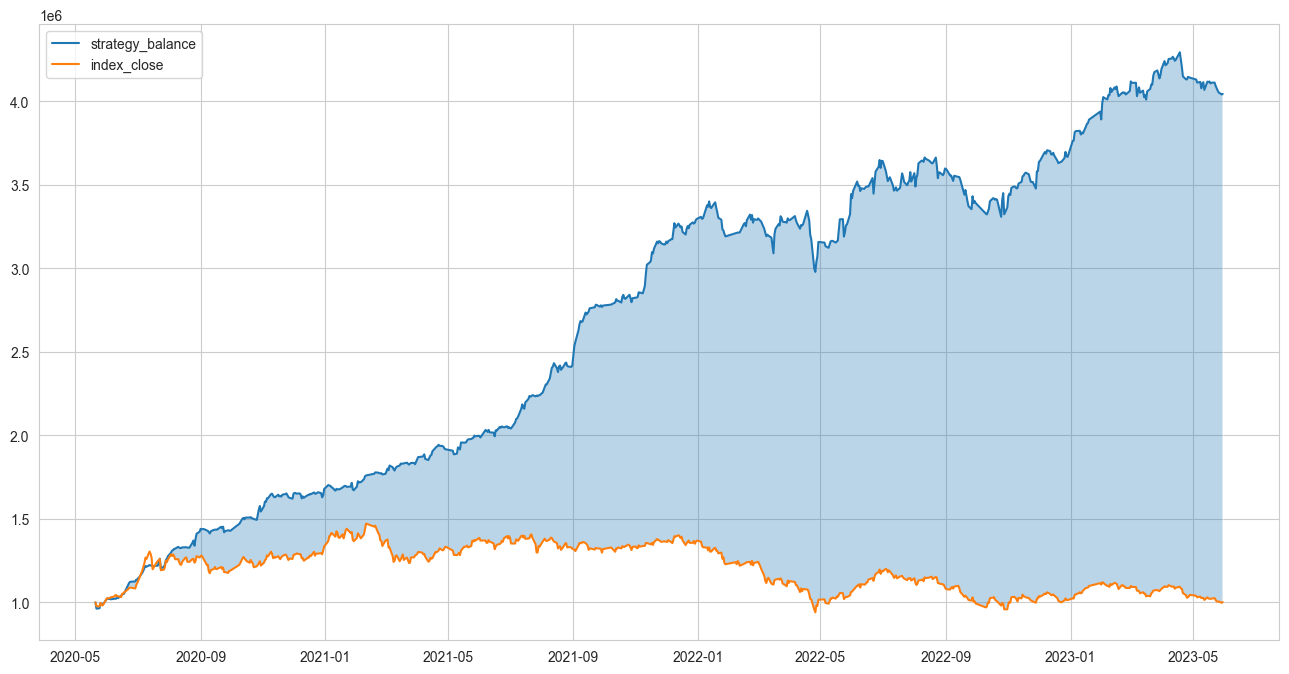

,alpha,beta,sharpe_ratio,index_sharpe_ratio,trade_days
2020,-0.004213,1.985093,1.608917,1.984591,146
2021,0.344814,0.500145,1.061678,-1.356652,232
2022,-0.009423,-0.061924,0.082059,-3.236674,230
2023,0.050101,0.117577,1.550111,0.335718,93
total,2.061746,-3.667279,1.677458,0.885748,701


,strategy_balance,index_close
date,,
2020-05-21,1.000000e+06,1.000000e+06
2020-05-22,9.629114e+05,9.778311e+05
2020-05-25,9.650640e+05,9.767134e+05
2020-05-26,9.953080e+05,9.972370e+05
2020-05-27,9.918913e+05,9.849984e+05
...,...,...
2023-05-24,4.078367e+06,1.006909e+06
2023-05-25,4.064238e+06,1.004720e+06
2023-05-26,4.052689e+06,1.005925e+06


In [62]:
# show back test 3

def show_back_test_three(back_test_three):
    #将date列转换为datetime类型
    back_test_three['date'] = pd.to_datetime(back_test_three['date'],format='%Y%m%d')
    #将date列设置为index
    back_test_three.set_index('date',inplace=True)
    #读取大盘指数数据
    index_data = pd.read_csv('index_data.csv')
    #将trade_date列转换为datetime类型
    index_data['trade_date'] = pd.to_datetime(index_data['trade_date'],format='%Y%m%d')
    #将trade_date列设置为index
    index_data.set_index('trade_date',inplace=True)
    #drop掉index_data中不需要的列(ts_code)
    index_data.drop(['ts_code'],axis=1,inplace=True)
    #将close改名为index_close
    index_data.rename(columns={'close':'index_close'},inplace=True)

    #将index_data的收盘价与back_test_three合并
    back_test_three = pd.merge(back_test_three,index_data,left_index=True,right_index=True,how='left')

    # 将index_close scale到与strategy_balance相同的范围
    back_test_three['index_close'] = back_test_three['index_close'] / back_test_three['index_close'].values[0] * back_test_three['strategy_balance'].values[0]

    #将index_close和strategy_balance转化为float类型
    back_test_three['index_close'] = back_test_three['index_close'].astype('float')
    back_test_three['strategy_balance'] = back_test_three['strategy_balance'].astype('float')

    #画图
    plt.figure(figsize=(16,8))
    plt.plot(back_test_three['strategy_balance'],label='strategy_balance')
    plt.plot(back_test_three['index_close'],label='index_close')
    #将strategy_balance在index_close上方的部分标记为半透明蓝色
    plt.fill_between(back_test_three.index,back_test_three['strategy_balance'],back_test_three['index_close'],where=back_test_three['strategy_balance']>=back_test_three['index_close'],alpha=0.3)

    plt.legend()
    plt.show()

    #创建一个表格，橫向为alpha，beta，sharpe_ratio,纵向为年份，最后一行为总计
    alpha_list = []
    beta_list = []
    sharpe_ratio_list = []
    #将月份添加到month_list中，保留年份和月份
    year_list = back_test_three.index.strftime('%Y').unique()
    #设置表格
    stat = pd.DataFrame(columns=['alpha','beta','sharpe_ratio','index_sharpe_ratio','trade_days'])
   
    for i in year_list:
        #计算策略收益率
        profit_rate = back_test_three[back_test_three.index.strftime('%Y')==i]['strategy_balance']
        #计算大盘收益率
        index_profit_rate = back_test_three[back_test_three.index.strftime('%Y')==i]['index_close']
        #将profit_rate与index_profit_rate转换为百分比
        profit_rate = profit_rate / profit_rate.values[0] - 1
        index_profit_rate = index_profit_rate / index_profit_rate.values[0] - 1
        
        #计算贝塔
        covariance = profit_rate.cov(index_profit_rate)
        variacne = index_profit_rate.var()
        beta = covariance / variacne

        #固定年化利率
        interest_rate = 0.03
        #计算阿尔法
        alpha = profit_rate.mean() - interest_rate - beta * (index_profit_rate.mean() - interest_rate)
        #计算夏普比率
        sharpe_ratio = (profit_rate.mean() - interest_rate) / profit_rate.std()
        #将阿尔法、贝塔、夏普比率添加到对应的列表中
        alpha_list.append(alpha)
        beta_list.append(beta)
        sharpe_ratio_list.append(sharpe_ratio)
        #计算当年交易次数
        trade_days = len(back_test_three[back_test_three.index.strftime('%Y')==i])
        #计算大盘的夏普比率
        index_sharpe_ratio = (index_profit_rate.mean() - interest_rate) / index_profit_rate.std()

        #保存到表格中
        stat.loc[i,'alpha'] = alpha
        stat.loc[i,'beta'] = beta
        stat.loc[i,'sharpe_ratio'] = sharpe_ratio
        stat.loc[i,'trade_days'] = trade_days
        stat.loc[i,'index_sharpe_ratio'] = index_sharpe_ratio


       
    #将index设置为year_list
    stat = stat.set_index(year_list)

    #计算总的alpha，beta，sharpe_ratio，index_sharpe_ratio，trade_days
    profit_rate = back_test_three['strategy_balance']
    index_profit_rate = back_test_three['index_close']
    profit_rate = profit_rate / profit_rate.values[0] - 1
    index_profit_rate = index_profit_rate / index_profit_rate.values[0] - 1

    #计算贝塔
    covariance = profit_rate.cov(index_profit_rate)
    variacne = index_profit_rate.var()
    total_beta = covariance / variacne

    #固定年化利率
    interest_rate = 0.03
    #将年化利率转换为与back_test_three相同的时间段
    interest_rate = interest_rate * (len(back_test_three) / 250)

    #计算阿尔法
    total_alpha = profit_rate.mean() - interest_rate - total_beta * (index_profit_rate.mean() - interest_rate)
    #计算夏普比率
    total_sharpe_ratio = (profit_rate.mean() - interest_rate) / profit_rate.std()
    #计算大盘的夏普比率
    total_index_sharpe_ratio = (index_profit_rate.mean() - interest_rate) / index_profit_rate.std()

    #将总的alpha，beta，sharpe_ratio添加到stat中，index为total
    stat = pd.concat([stat,pd.DataFrame({'alpha':total_alpha,'beta':total_beta,'sharpe_ratio':total_sharpe_ratio,'index_sharpe_ratio':total_index_sharpe_ratio,'trade_days':len(back_test_three)},index=['total'])])

    #显示表格
    display(stat.style.background_gradient(cmap='summer_r'))
  

    return back_test_three

    
back_test_three = back_test_three_copy.copy()

show_back_test_three(back_test_three)

In [63]:

def trading_strategy_four(begin_date,intial_cash):

    current_date = begin_date
    holding_value = 0
    cash_hold = intial_cash
    holding_stock_code = []
    sell_date = {}
    purchase_price = {}
    purchase_num = {}

    #若current_date在20230509之前，则执行策略
    # begin_buy_date = buy_date

    #创建一个dataframe，储存balance,trade_line
    back_test_four = pd.DataFrame(columns=['date','strategy_balance'])

    while current_date < 20230509:
  

        holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value,buy_date = holding_info(holding_stock_code, purchase_price, purchase_num, cash_hold, holding_value, data, date_range,current_date,missing_date_dict)

        #保存buy_date,只运行一次
        if current_date == begin_date:
            begin_buy_date = buy_date
            #将初始日期的balance保存到back_test_three中
            # back_test_four = back_test_four.append({'date':begin_buy_date,'strategy_balance':intial_cash},ignore_index=True)
            back_test_four = pd.concat([back_test_four,pd.DataFrame({'date':begin_buy_date,'strategy_balance':intial_cash},index=[0])],ignore_index=True)

        current_date,final_balance,outcome_detail = trade_test3(data, holding_stock_code, purchase_price, purchase_num, sell_date, max_holding_days, date_range,holding_value,cash_hold,buy_date,3,end_date=20230619)

        #更新下一次交易的cash_hold
        cash_hold = final_balance

        # 将每次的outcome_detail添加到back_test_three中
        # back_test_four = back_test_four.append(outcome_detail,ignore_index=True)
        back_test_four = pd.concat([back_test_four,outcome_detail],ignore_index=True)

    return back_test_four


In [64]:
#读取index_close
index_close = pd.read_csv('index_data.csv')[['trade_date','close']]
#将trade_date转换为datetime格式
index_close['trade_date'] = pd.to_datetime(index_close['trade_date'],format='%Y%m%d')
#将trade_date设置为index
index_close = index_close.set_index('trade_date')
#只保留与date_range相同的日期
date_range_copy = date_range.copy()
#将date_range_copy转换为datetime格式
date_range_copy = pd.to_datetime(date_range_copy,format='%Y%m%d')
#只保留与index_close相同的日期
index_close = index_close[index_close.index.isin(date_range_copy)]
#删除最后一位
index_close = index_close[:-2]
#将index_close的顺序反转
index_close = index_close.iloc[::-1]
#对index_close进行scale，第一个close为1000000
index_close = index_close / index_close.iloc[0] * 1000000

#从第一位开始提取每4个月一次的日期
date_range_half_year = date_range[2::100]

#删除最后一个日期
date_range_half_year = date_range_half_year[:-1]

print(date_range_half_year)

#对每个日期进行回测
for date in date_range_half_year:
    begin_date = date
    date_datetime = pd.to_datetime(date,format='%Y%m%d')
    intial_cash = index_close.loc[date_datetime,'close']

    back_test_four = trading_strategy_four(begin_date,intial_cash)

    #存储每一个back_test_four
    back_test_four.to_csv(f'show_back_test/back_test_four/back_test_four_{date}.csv')


748    20200521
648    20201020
548    20210317
448    20210811
348    20220110
248    20220614
148    20221109
Name: trade_date, dtype: int32


,alpha,beta,sharpe_ratio,index_sharpe_ratio,trade_days
2020-05-22,1.825538,-3.154874,1.638288,1.063616,701
2020-10-21,0.538243,-2.376149,1.846635,-0.898544,601
2021-03-18,0.313172,-2.157523,1.945957,-1.302368,501
2021-08-12,-0.010357,-0.710873,0.978888,-2.256483,401
2022-01-11,-0.055042,-0.072247,-0.494283,-3.496240,321
2022-06-15,0.045171,0.542947,0.183315,-1.383268,221
2022-11-10,0.029885,1.192441,1.490896,1.135390,121


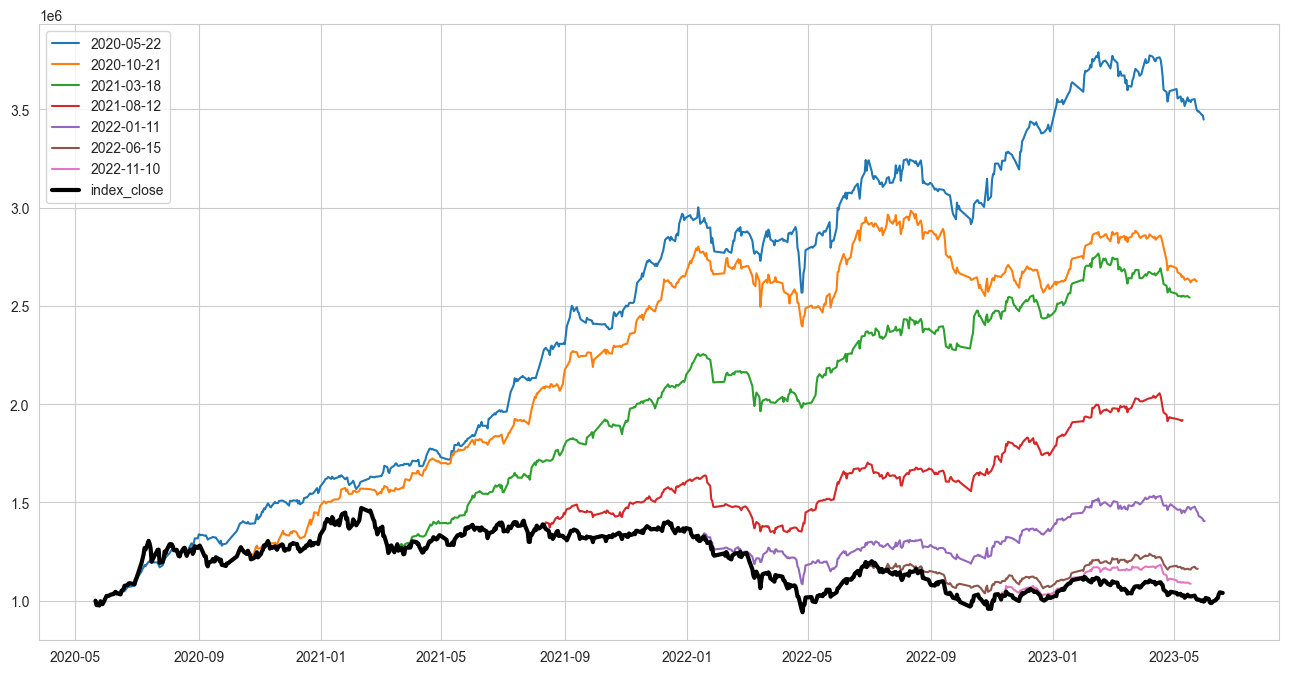

In [66]:
#读取back_test_four的每一个csv文件
back_test_four_list = []
for file in os.listdir('show_back_test/back_test_four'):
    back_test_four_list.append(pd.read_csv(f'show_back_test/back_test_four/{file}'))

#创建一个dataframe，储存alpha，beta，sharpe_ratio,index_share_ratio
stat_four = pd.DataFrame(columns=['alpha','beta','sharpe_ratio','index_sharpe_ratio','trade_days'])

#将所有back_test_four画在一张图上
plt.figure(figsize=(16,8))

for back_test_four in back_test_four_list[:-1]:
    #读取起始日期
    date_begin = back_test_four['date'].iloc[0]
    #将date_begin列转换为datetime类型,只保留年月日
    date_begin = pd.to_datetime(date_begin,format='%Y%m%d')
    date_begin = date_begin.strftime('%Y-%m-%d')
    #将date列转换为datetime类型,只保留年月日
    back_test_four['date'] = pd.to_datetime(back_test_four['date'],format='%Y%m%d')
   #将date列转换为datetime类型
    back_test_four['date'] = pd.to_datetime(back_test_four['date'],format='%Y%m%d')
    #将date列设置为index
    back_test_four.set_index('date',inplace=True)
    #drop掉index_data中不需要的列Unnamed: 0
    back_test_four.drop(['Unnamed: 0'],axis=1,inplace=True)

    #提取时间段,保存index_close中与这个时间段相同的数据
    index_close_four = index_close[index_close.index.isin(back_test_four.index)]
    

    profit_rate = back_test_four['strategy_balance']
    index_profit_rate = index_close_four['close']
    #将profit_rate与index_profit_rate转换为百分比
    profit_rate = profit_rate / profit_rate.values[0] - 1
    index_profit_rate = index_profit_rate / index_profit_rate.values[0] - 1



    #计算贝塔
    covariance = profit_rate.cov(index_profit_rate)
    variacne = index_profit_rate.var()
    beta = covariance / variacne
    #固定年化利率
    interest_rate = 0.03
    #将年化利率转换为与back_test_four相同的时间段
    interest_rate = interest_rate * (len(back_test_four) / 250)

    #计算阿尔法
    alpha = profit_rate.mean() - interest_rate - beta * (index_profit_rate.mean() - interest_rate)
    #计算夏普比率
    sharpe_ratio = (profit_rate.mean() - interest_rate) / profit_rate.std()
    #计算大盘的夏普比率
    index_sharpe_ratio = (index_profit_rate.mean() - interest_rate) / index_profit_rate.std()

    #保存到stat_four中
    stat_four.loc[date_begin,'alpha'] = alpha
    stat_four.loc[date_begin,'beta'] = beta
    stat_four.loc[date_begin,'sharpe_ratio'] = sharpe_ratio
    stat_four.loc[date_begin,'index_sharpe_ratio'] = index_sharpe_ratio
    stat_four.loc[date_begin,'trade_days'] = len(back_test_four)


    #画图
    plt.plot(back_test_four['strategy_balance'],label=f'{date_begin}')


#展示stat_four
display(stat_four.style.background_gradient(cmap='summer_r'))

#将index_close画在一张图上,用黑色加粗
plt.plot(index_close['close'],label='index_close',color='black',linewidth=3)

plt.legend()
plt.show()


